In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
print(pd.__version__)

2.0.3


1. `air_reserve.csv`: This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.
    - air_store_id - the restaurant's id in the air system
    - visit_datetime - the time of the reservation
    - reserve_datetime - the time the reservation was made
    - reserve_visitors - the number of visitors for that reservation
2. `hpg_reserve.csv`: This file contains reservations made in the hpg system.
    - hpg_store_id - the restaurant's id in the hpg system
    - visit_datetime - the time of the reservation
    - reserve_datetime - the time the reservation was made
    - reserve_visitors - the number of visitors for that reservation
3. `air_store_info.csv`: This file contains information about select air restaurants. Column names and contents are self-explanatory
    - air_store_id
    - air_genre_name
    - air_area_name
    - latitude
    - longitude
    Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
4. `hpg_store_info.csv`: This file contains information about select hpg restaurants. Column names and contents are self-explanatory.
    - hpg_store_id
    - hpg_genre_name
    - hpg_area_name
    - latitude
    - longitude
    Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
5. `store_id_relation.csv`: This file allows you to join select restaurants that have both the air and hpg system.
    - hpg_store_id
    - air_store_id
6. `air_visit_data.csv`: This file contains historical visit data for the air restaurants.
    - air_store_id
    - visit_date - the date
    - visitors - the number of visitors to the restaurant on the date
7. `sample_submission.csv`: This file shows a submission in the correct format, including the days for which you must forecast.
    - id - the id is formed by concatenating the air_store_id and visit_date with an underscore
    - visitors- the number of visitors forecasted for the store and date combination
8. `date_info.csv`: This file gives basic information about the calendar dates in the dataset. 
    - calendar_date
    - day_of_week
    - holiday_flg - is the day a holiday in Japan

In [134]:
air_reserve = pd.read_csv('data/air_reserve.csv', parse_dates=['reserve_datetime'])
hpg_reserve = pd.read_csv('data/hpg_reserve.csv', parse_dates=['reserve_datetime'])
air_store_info = pd.read_csv('data/air_store_info.csv')
hpg_store_info = pd.read_csv('data/hpg_store_info.csv')
store_id_relation = pd.read_csv('data/store_id_relation.csv')
air_visit_data = pd.read_csv('data/air_visit_data.csv', parse_dates=['visit_date'])
date_info = pd.read_csv('data/date_info.csv')
sample_df = pd.read_csv('data/sample_submission.csv')

### `sample_submission.csv` (`sample_df`) to identify stores and dates to predict

In [135]:
sample_df.head()


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [136]:
split_cols = sample_df.id.str.split('([a-z0-9_]{20})_', expand=True, regex=True)
sample_df_new = pd.concat([sample_df, split_cols.loc[:, 1:]], axis=1)
sample_df_new.head()

,id,visitors,1,2
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27


In [137]:
sample_df_new = sample_df_new.rename(columns={1: 'air_store_id', 2: 'date'}).drop(['id', 'visitors'], axis=1)

In [138]:
sample_df_new.head()

,air_store_id,date
0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9,2017-04-27


In [139]:
len(sample_df_new.air_store_id.unique())

821

In [140]:
sample_df_new.air_store_id.value_counts(sort=True)

air_store_id
air_00a91d42b08b08d9    39
air_a9a380530c1e121f    39
air_a55d17bd3f3033cb    39
air_a563896da3777078    39
air_a678e5b144ca24ce    39
                        ..
air_5dea8a7a5bf5eb71    39
air_5e339a1f364cdb00    39
air_5e34c6fe6fabd10e    39
air_5e70fe82f9e4fab6    39
air_fff68b929994bfbd    39
Name: count, Length: 821, dtype: int64

In [141]:
sample_df_new.date.min(), sample_df_new.date.max() 

('2017-04-23', '2017-05-31')

### Number of stores represented in each df

In [142]:
print(f'''
    number of unique ids in air_reserve: {len(air_reserve.air_store_id.unique())},
    number of unique ids in air_visit_data: {len(air_visit_data.air_store_id.unique())}, 
    number of unique ids in air_store_info: {len(air_store_info.air_store_id.unique())},
    unique air_store_id in store_id_relation: {len(store_id_relation.air_store_id.unique())},
    unique ids in sample_df: {len(sample_df_new.air_store_id.unique())},
    unique ids in both air_visit_data and prediction: {len(air_visit_data[air_visit_data.air_store_id.isin(sample_df_new.air_store_id) == True].air_store_id.unique())}    
    ''')


    number of unique ids in air_reserve: 314,
    number of unique ids in air_visit_data: 829, 
    number of unique ids in air_store_info: 829,
    unique air_store_id in store_id_relation: 150,
    unique ids in sample_df: 821,
    unique ids in both air_visit_data and prediction: 821    
    


In [143]:
print(f'''
    number of unique ids in hpg_reserve: {len(hpg_reserve.hpg_store_id.unique())},
    number of unique ids in hpg_store_info: {len(hpg_store_info.hpg_store_id.unique())},
    unique hpg_store_id in store_id_relation: {len(store_id_relation.hpg_store_id.unique())}
    ''')


    number of unique ids in hpg_reserve: 13325,
    number of unique ids in hpg_store_info: 4690,
    unique hpg_store_id in store_id_relation: 150
    


# EDA - `air_visit_data`

In [144]:
# pivot dataframe
air_visit_data_pivoted = air_visit_data[air_visit_data.air_store_id.isin(sample_df_new.air_store_id)].pivot(columns='visit_date', index='air_store_id', values='visitors')

## 1. Time scope

In [145]:
print(f'scope of visit data: {air_visit_data.visit_date.min()} ~ {air_visit_data.visit_date.max()}')

scope of visit data: 2016-01-01 00:00:00 ~ 2017-04-22 00:00:00


In [147]:
from datetime import timedelta
air_visit_data.visit_date.max() - air_visit_data.visit_date.min() + timedelta(days=1)

Timedelta('478 days 00:00:00')

## 2. Missing data

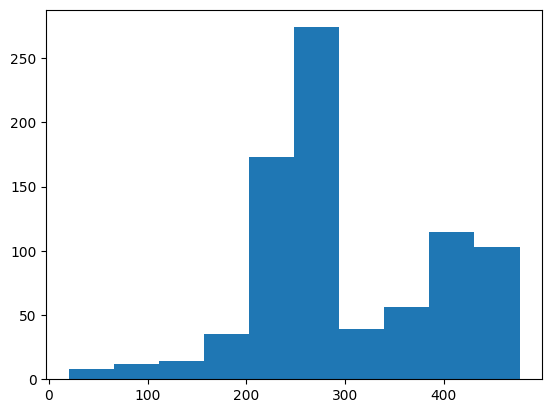

In [148]:
# number of data points for per ID - distribution
air_visit_data_count = pd.DataFrame(air_visit_data.dropna().air_store_id.value_counts()).rename(columns={'count':'data_points'})
plt.hist('data_points', data=air_visit_data_count)
plt.show()

In [149]:
air_visit_data_pivoted.head()

visit_date,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,...,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.0,39.0,NaN,NaN,19.0,35.0,17.0,38.0,55.0,18.0
air_0164b9927d20bcc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,7.0,1.0,NaN,2.0,1.0,8.0,1.0,26.0,6.0
air_0241aa3964b7f861,NaN,NaN,10.0,9.0,17.0,10.0,NaN,5.0,8.0,16.0,...,NaN,4.0,15.0,10.0,12.0,19.0,8.0,NaN,3.0,13.0
air_0328696196e46f18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,4.0,3.0,3.0,NaN,24.0,NaN,19.0,8.0
air_034a3d5b40d5b1b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,18.0,31.0,39.0,25.0,20.0,31.0,12.0,37.0,35.0


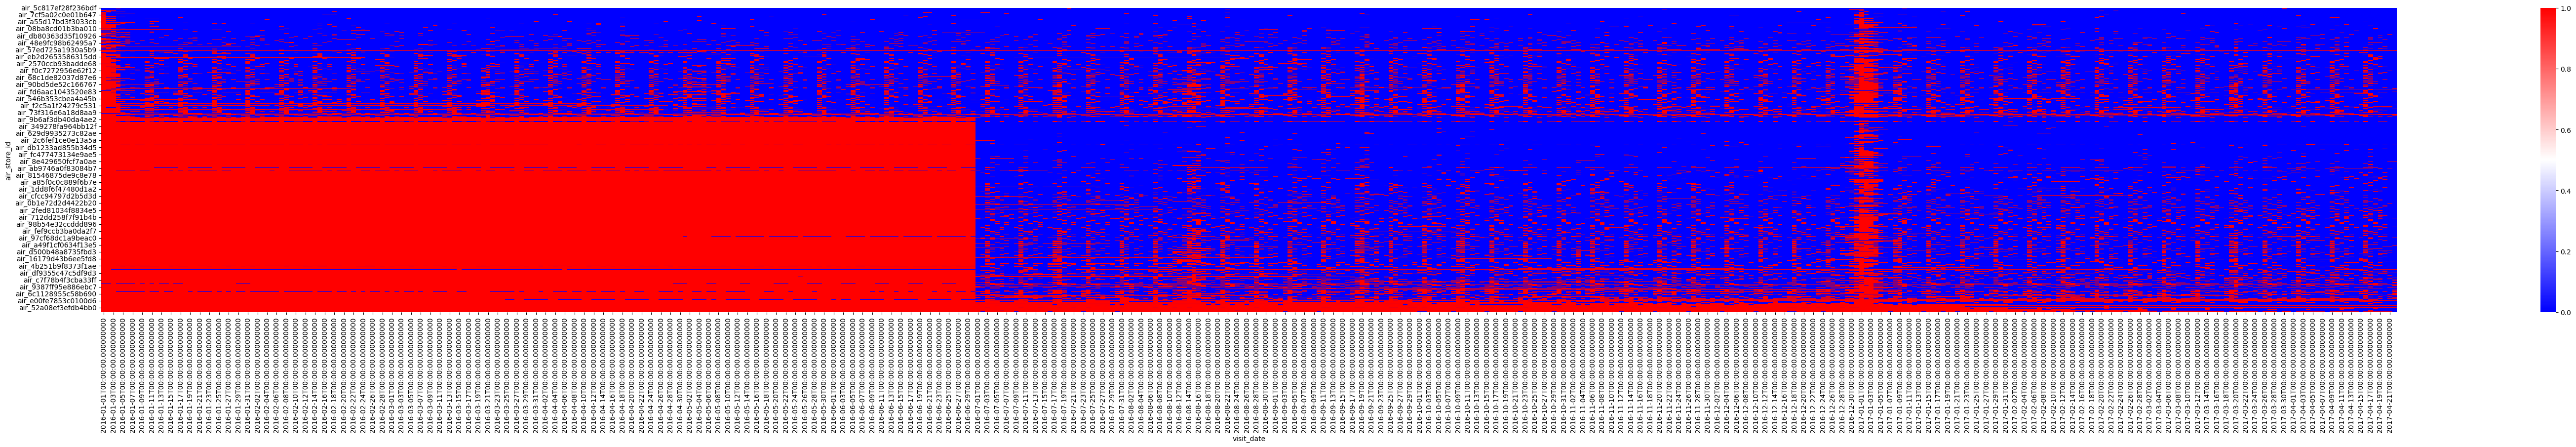

In [150]:
fig, ax = plt.subplots(figsize=(75,8))
sorter = air_visit_data.groupby('air_store_id').agg({'visitors':'count'}).sort_values('visitors', ascending=False).index

sns.heatmap(air_visit_data_pivoted.reindex(sorter).isna(), cmap='bwr')
fig.show()

In [151]:
air_visit_data_pivoted.isna()['2016-07-01'].value_counts()

2016-07-01 00:00:00
False    750
True      71
Name: count, dtype: int64

In [152]:
air_visit_data_pivoted.isna()['2016-06-30'].value_counts()

2016-06-30 00:00:00
True     531
False    290
Name: count, dtype: int64

- most of restaurants have no data until July 2016 
    - 750 restaurants have data on 1 Jul 2016 (vs. 290 on 30 Jun 2016)
- there's a regular pattern in missing data (weekly?) and there's a bigger patch of missing data around Obon holidays and new year time

### Replace NaN

In [153]:
# replace all NaNs with zero
air_visit_data_pivoted_replaced = air_visit_data_pivoted.fillna(value=0)

In [154]:
# only use data from July (where most stores have data)
air_visit_data_pivoted_july = air_visit_data_pivoted_replaced.loc[:, '2016-07-01':]
air_visit_data_pivoted_july.head()

visit_date,2016-07-01,2016-07-02,2016-07-03,2016-07-04,2016-07-05,2016-07-06,2016-07-07,2016-07-08,2016-07-09,2016-07-10,...,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9,35.0,9.0,0.0,20.0,25.0,29.0,34.0,42.0,11.0,0.0,...,34.0,39.0,0.0,0.0,19.0,35.0,17.0,38.0,55.0,18.0
air_0164b9927d20bcc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,7.0,1.0,0.0,2.0,1.0,8.0,1.0,26.0,6.0
air_0241aa3964b7f861,10.0,13.0,20.0,4.0,7.0,10.0,1.0,2.0,7.0,3.0,...,0.0,4.0,15.0,10.0,12.0,19.0,8.0,0.0,3.0,13.0
air_0328696196e46f18,0.0,0.0,11.0,4.0,6.0,4.0,8.0,8.0,12.0,4.0,...,0.0,9.0,4.0,3.0,3.0,0.0,24.0,0.0,19.0,8.0
air_034a3d5b40d5b1b1,19.0,23.0,5.0,13.0,0.0,10.0,3.0,23.0,12.0,13.0,...,22.0,18.0,31.0,39.0,25.0,20.0,31.0,12.0,37.0,35.0


In [155]:
# keep IDs where there's some data in the first week of Jul 2016
ids_to_keep = air_visit_data_pivoted_july.loc[:, :'2016-07-08'].sum(axis=1).sort_values()
ids_to_keep = ids_to_keep[ids_to_keep > 0].index
len(ids_to_keep)

786

In [156]:
# filter for IDs to keep
air_visit_data_pivoted_july = air_visit_data_pivoted_july[air_visit_data_pivoted_july.index.isin(ids_to_keep)]
air_visit_data_pivoted_july.shape

(786, 296)

### Correlation between dates - latest 30 days

<AxesSubplot:xlabel='visit_date', ylabel='visit_date'>

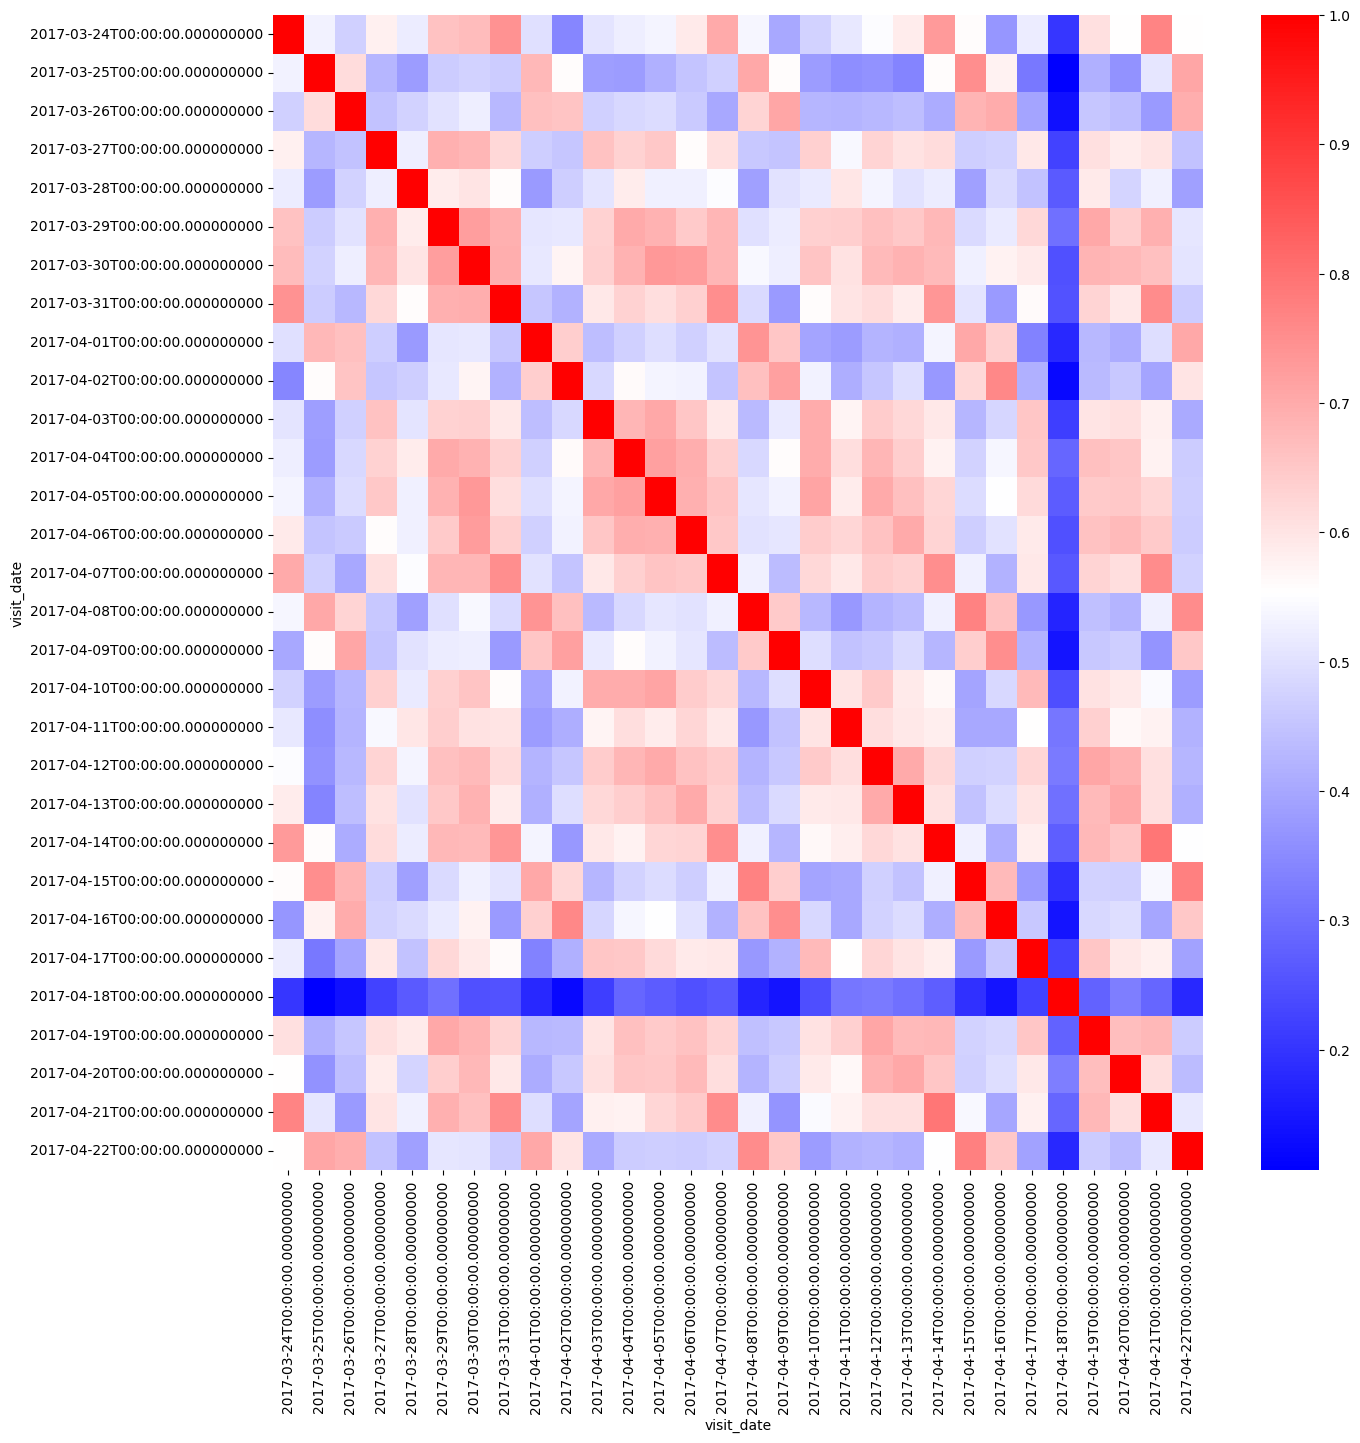

In [157]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(air_visit_data_pivoted.iloc[:,-30:].corr(), cmap='bwr')

- Higher correlation with the same day of the week

### Baseline
Linear regression

In [ ]:
# reverse the order of columns
# air_visit_data_pivoted[air_visit_data_pivoted.columns[::-1]]

In [179]:
# train test split

train_size = round(air_visit_data_pivoted_july.shape[1] * .5)
test_size = air_visit_data_pivoted_july.shape[1] - train_size

print(f'train_size = {train_size}, test_size = {test_size}')


train_size = 148, test_size = 148


In [180]:
train_x = air_visit_data_pivoted_july.iloc[:, :train_size-1]
train_y = air_visit_data_pivoted_july.iloc[:, train_size-1:train_size]
test_x = air_visit_data_pivoted_july.iloc[:, train_size:-1]
test_y = air_visit_data_pivoted_july.iloc[:, -1:]


In [181]:
def make_weekly(x, y):
    date_list = []
    date = y.columns[0]
    
    while date > x.columns.min():
        date = date - timedelta(days=7)
        if date >= x.columns.min():
            date_list.append(date)
    
    x_weekly = x.filter(date_list, axis=1)
    
    return x_weekly
        

In [182]:
train_x_weekly = make_weekly(train_x, train_y)

In [183]:
train_x_weekly.head()

visit_date,2016-11-18,2016-11-11,2016-11-04,2016-10-28,2016-10-21,2016-10-14,2016-10-07,2016-09-30,2016-09-23,2016-09-16,...,2016-09-02,2016-08-26,2016-08-19,2016-08-12,2016-08-05,2016-07-29,2016-07-22,2016-07-15,2016-07-08,2016-07-01
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9,54.0,31.0,43.0,28.0,34.0,57.0,31.0,41.0,29.0,34.0,...,26.0,39.0,43.0,0.0,42.0,31.0,53.0,28.0,42.0,35.0
air_0241aa3964b7f861,0.0,16.0,4.0,9.0,6.0,2.0,4.0,4.0,22.0,0.0,...,10.0,7.0,7.0,0.0,5.0,3.0,4.0,4.0,2.0,10.0
air_0328696196e46f18,5.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,0.0,...,0.0,8.0,1.0,0.0,1.0,5.0,0.0,5.0,8.0,0.0
air_034a3d5b40d5b1b1,9.0,17.0,7.0,7.0,11.0,6.0,13.0,9.0,7.0,7.0,...,13.0,20.0,25.0,20.0,18.0,18.0,22.0,24.0,23.0,19.0
air_036d4f1ee7285390,16.0,31.0,33.0,18.0,18.0,20.0,22.0,19.0,14.0,34.0,...,27.0,31.0,25.0,0.0,29.0,14.0,23.0,28.0,29.0,37.0


In [184]:
from sklearn.linear_model import LinearRegression
model_linreg = LinearRegression()
model_linreg.fit(train_x_weekly, train_y)

LinearRegression()

In [185]:
model_linreg

LinearRegression()

In [186]:
test_x_weekly = make_weekly(test_x, test_y)

In [187]:
test_x_weekly

visit_date,2017-04-15,2017-04-08,2017-04-01,2017-03-25,2017-03-18,2017-03-11,2017-03-04,2017-02-25,2017-02-18,2017-02-11,...,2017-01-28,2017-01-21,2017-01-14,2017-01-07,2016-12-31,2016-12-24,2016-12-17,2016-12-10,2016-12-03,2016-11-26
air_store_id,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9,0.0,9.0,7.0,7.0,4.0,9.0,18.0,11.0,18.0,0.0,...,7.0,11.0,17.0,21.0,0.0,99.0,17.0,14.0,5.0,17.0
air_0241aa3964b7f861,15.0,4.0,7.0,14.0,13.0,11.0,6.0,8.0,15.0,6.0,...,16.0,11.0,6.0,9.0,6.0,14.0,23.0,9.0,0.0,14.0
air_0328696196e46f18,4.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,...,7.0,10.0,0.0,5.0,0.0,0.0,0.0,22.0,0.0,0.0
air_034a3d5b40d5b1b1,31.0,40.0,20.0,15.0,33.0,31.0,29.0,51.0,23.0,26.0,...,0.0,0.0,6.0,5.0,0.0,22.0,11.0,11.0,20.0,15.0
air_036d4f1ee7285390,22.0,15.0,7.0,23.0,25.0,20.0,27.0,22.0,33.0,4.0,...,15.0,37.0,34.0,34.0,0.0,13.0,6.0,13.0,31.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
air_fea5dc9594450608,20.0,31.0,33.0,13.0,23.0,25.0,15.0,26.0,35.0,24.0,...,25.0,19.0,17.0,21.0,0.0,25.0,44.0,17.0,27.0,18.0
air_fee8dcf4d619598e,47.0,31.0,38.0,45.0,16.0,40.0,27.0,24.0,36.0,48.0,...,42.0,37.0,36.0,28.0,0.0,0.0,50.0,49.0,34.0,41.0
air_fef9ccb3ba0da2f7,23.0,20.0,10.0,12.0,7.0,11.0,5.0,8.0,5.0,3.0,...,7.0,8.0,8.0,6.0,0.0,0.0,26.0,6.0,8.0,14.0


In [188]:
pred_linleg = model_linreg.predict(test_x_weekly)

In [190]:
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(test_y, pred_linleg)

0.4930648578574736

Stationarity of data

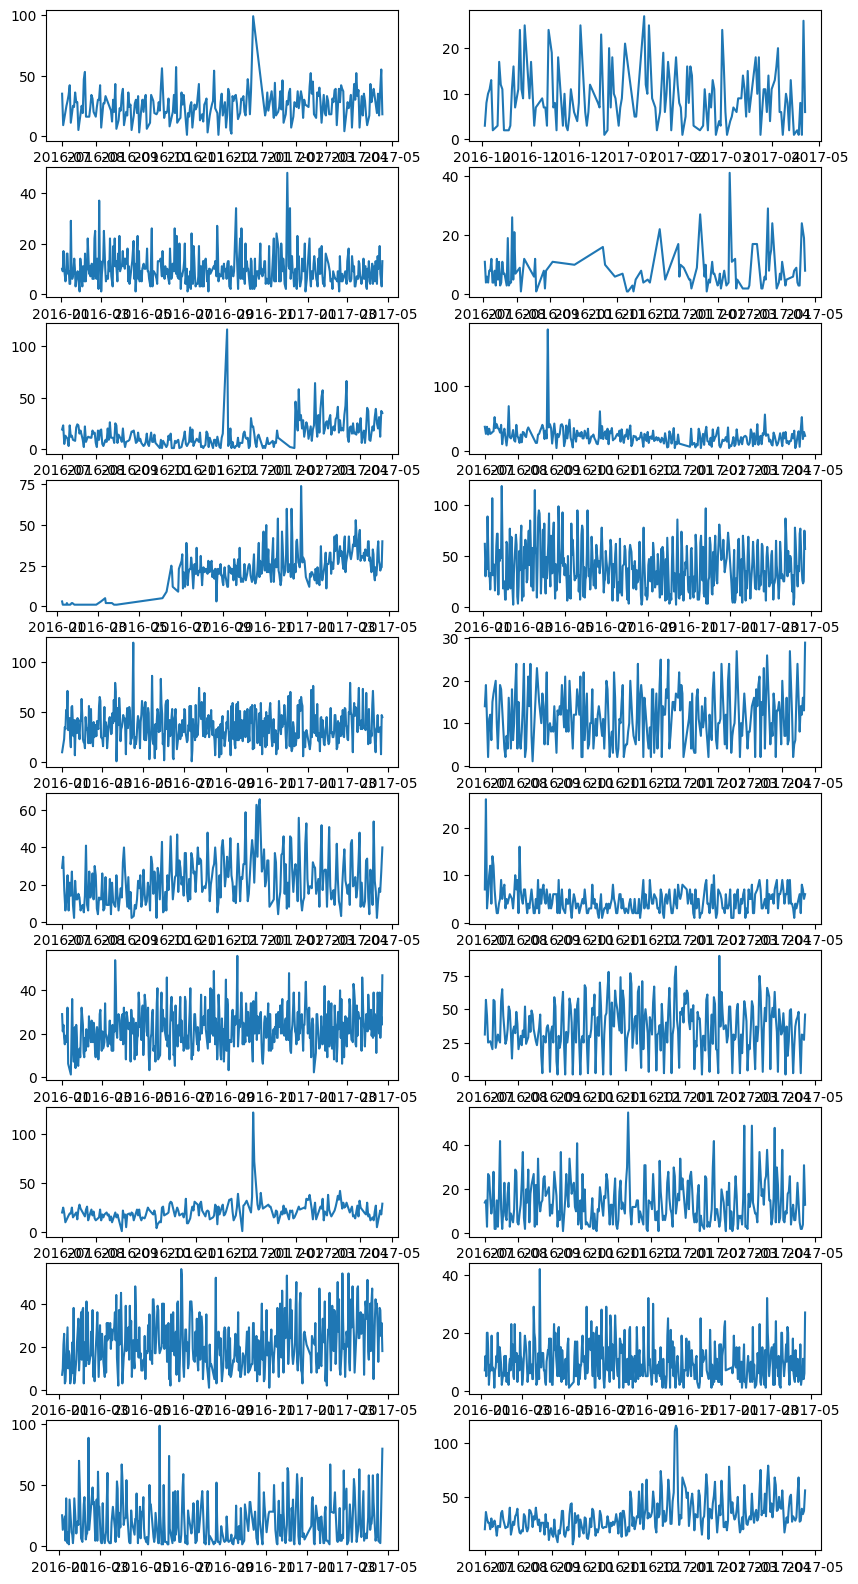

In [ ]:
fig, ax = plt.subplots(10, 2, figsize=(10,20))

for i in range(20):
    x = i//2
    y = i%2
    ax[x, y].plot(
        'visit_date',
        'visitors',
        data=air_visit_data[air_visit_data.air_store_id==air_visit_data.groupby('air_store_id').agg({'visitors':'count'}).index[i]],
        )

<AxesSubplot:xlabel='visit_date', ylabel='visit_date'>

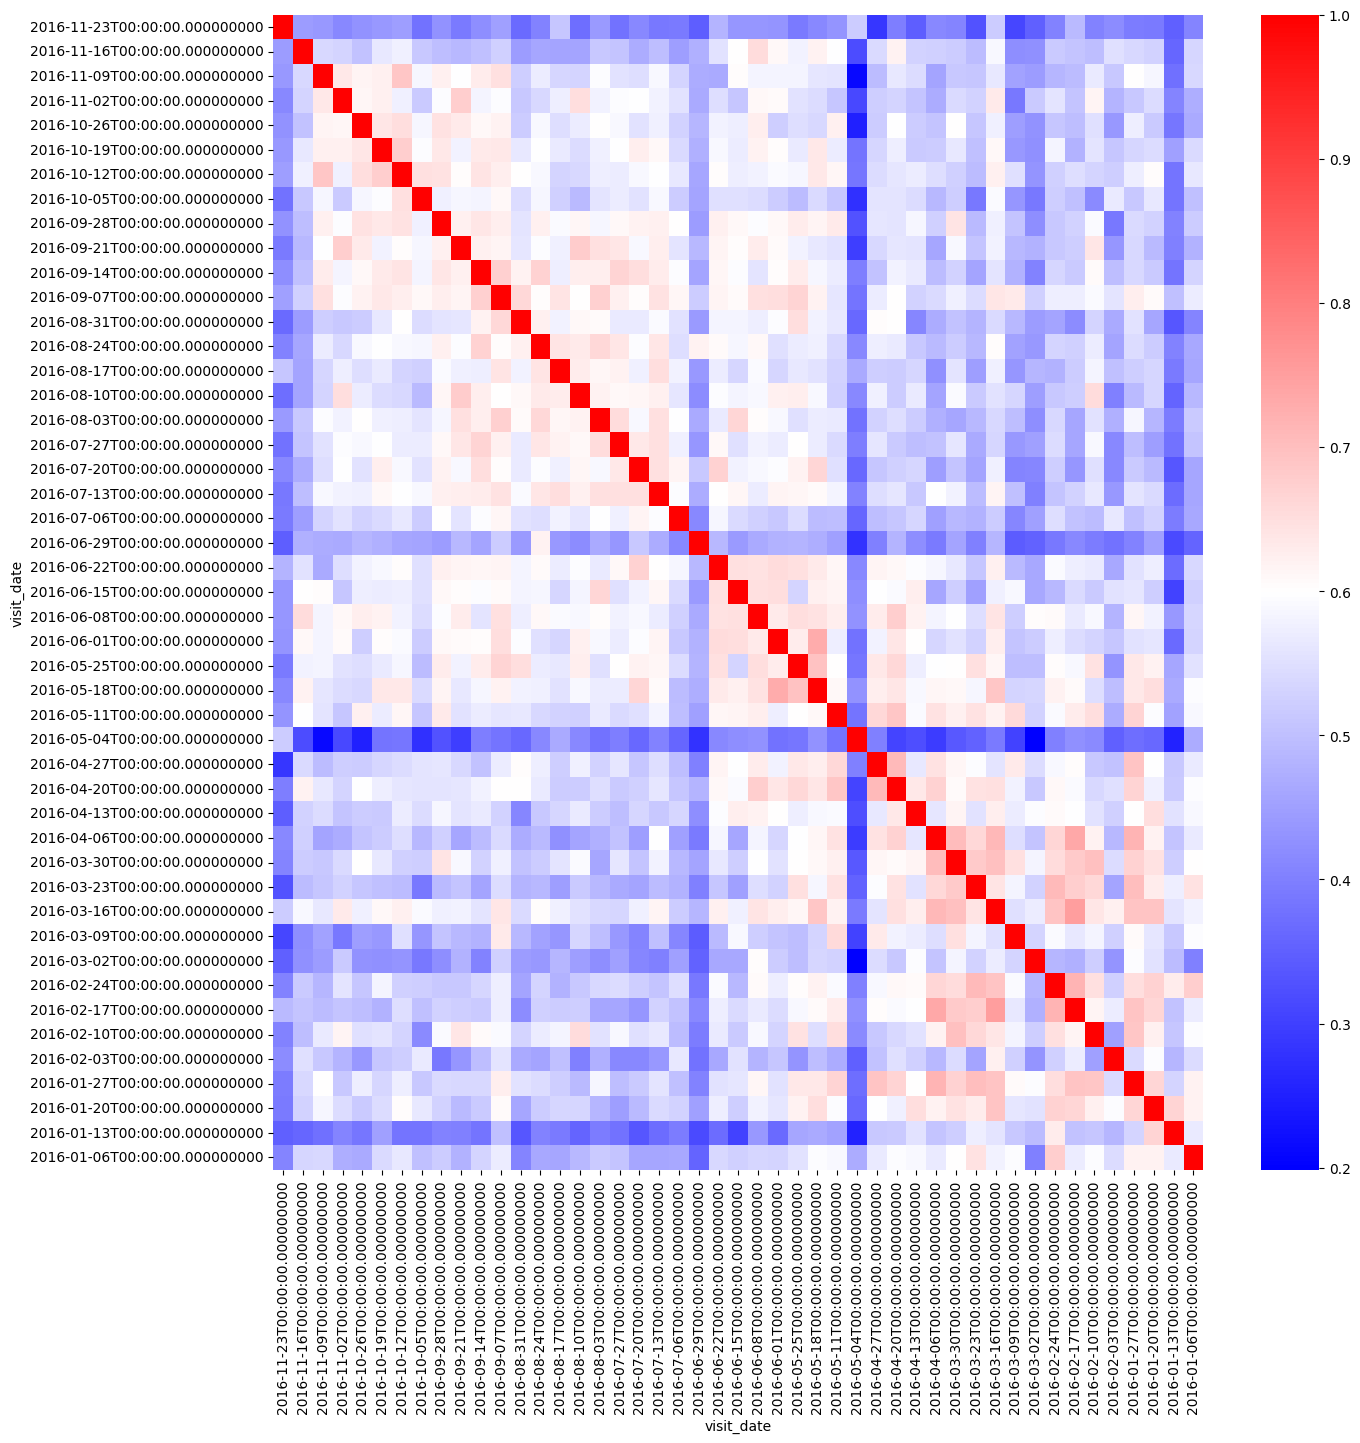

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(train_x_weekly.corr(), cmap='bwr')

In [ ]:
# filling NaNs
train_x_weekly_new = train_x_weekly[train_x_weekly.columns[::-1]].transpose()
train_x_weekly_new = train_x_weekly_new.fillna(train_x_weekly_new.mean()).transpose().dropna()